In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
import random
from constants_and_util import *
from test_on_simulated_data import *
import cyclic_HMM

This notebook illustrates how to run CyHMMs on continuous and binary data. We generate some continuous simulated data, some binary simulated data, and demonstrate that CyHMMs can recover the true simulation parameters. 

In [2]:
# set random seed for reproducibility
np.random.seed(42)
random.seed(42)
confirm_results_do_not_change = True # make sure that tinkering with the model didn't change any fitting parameters: useful for debugging and unit tests. 

First we generate some continuous simulated data by drawing from noisy sinusoids and adding in missing data. (See test_on_simulated_data.py for how exactly we generate the data). In the simulated data, the true average cycle length in the population is 30, and cycle lengths can vary slightly both within and between individuals. We plot one individual from the simulated population below. Note that the data is very noisy and the cycles are not at all visually obvious (at least, I can't see them).

**Important**: the data for the model should be in the following format: a list of arrays, where each array contains the data for one individual. The dimensions of the array should be n_timesteps_for_individual x n_features. Missing values in the data should be encoded as the special value missing_data_val provided in constants_and_util.py. This is done for compatibility with the version of Pomegranate, the HMM library we wrap around, that we used in development. See the samples variable generated below for an example of how the data should look. 

The simulated data parameter setting is {'trial_number': 0, 'noise': 25, 'verbose': True, 'cycle_variance_within_individuals': 2, 'min_T': 90, 'K': 10, 'sinusoid_coefficient_variation': 0.2, 'N': 500, 'max_T': 90, 'data_is_binary': False, 'cycle_variance_between_individuals': 2, 'n_sinusoids': 1, 'missing_data_probability': 0.2, 'population_cycle_length': 30, 'name': 'max_T'}


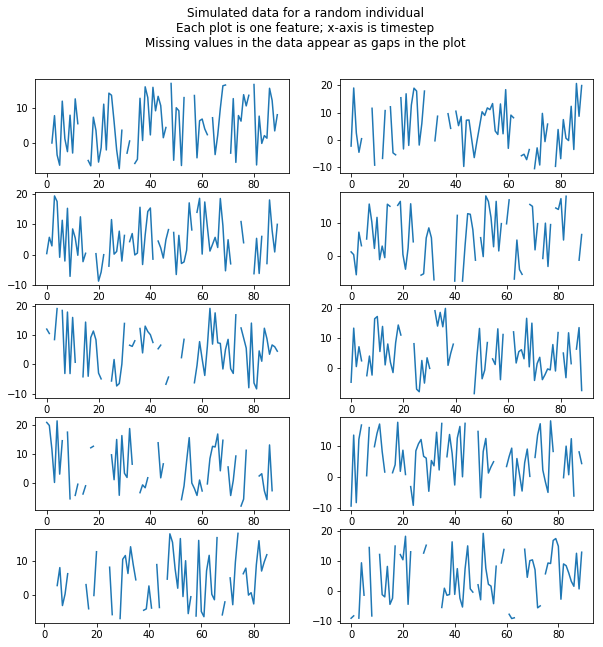

In [3]:
all_param_settings = generate_params_for_all_tests()
param_setting = all_param_settings[0]
print 'The simulated data parameter setting is', param_setting.__dict__
data_generator = simulatedDataGenerator(param_setting)
data_generator.generate_simulated_data()
samples = [a['sample'] for a in data_generator.all_individual_data]

Now we fit a CyHMM. Because the data is continuous, we use a Normal emission distribution with missing data. We initialize the model with a hypothesized duration 20, which is fairly far from the true average duration (30). In real-world use cases, you should initialize with your best guess of the true cycle length. n_processes controls the number of processes used in fitting the model; tweak this depending on your computing resources. 

In [4]:
model = cyclic_HMM.fit_cyhmm_model(n_states = 4, 
                                      samples = samples, 
                                      symptom_names = data_generator.symptoms, 
                                      max_iterations = 100, 
                                      duration_distribution_name = 'poisson', 
                                      emission_distribution_name = 'normal_with_missing_data', 
                                      hypothesized_duration = 20, 
                                      verbose = True, 
                                      n_processes = 5,
                                     min_iterations = 10)

Initializing emission parameters from samples
Initializing emission parameters from samples
Initializing emission parameters from samples
Initializing emission parameters from samples
Time to do all model fitting 1.32913088799
After iteration 0 (total time: 1.409) parameters are
                            0         1         2         3
duration_mean        3.999904  3.999659  3.999992  4.000674
duration_std         1.999975  1.999914  1.999997  2.000168
symptom_0_mean       5.034090  4.982801  4.930935  5.033271
symptom_0_p_missing  0.203490  0.202968  0.202364  0.202199
symptom_0_std        7.249785  7.245436  7.238497  7.252593
symptom_1_mean       5.190883  5.181638  5.216924  5.094145
symptom_1_p_missing  0.199491  0.201487  0.202879  0.202010
symptom_1_std        7.882671  7.880791  7.876264  7.870164
symptom_2_mean       5.065233  5.055789  5.097063  5.045745
symptom_2_p_missing  0.198738  0.198355  0.198976  0.205265
symptom_2_std        7.404013  7.410725  7.407164  7.393760


In [5]:
def confirm_params_remain_the_same(model, cached_params_filename):
    """
    Small helper method to confirm the learned parameters don't change when we tinker around with the model. 
    Useful for potential future unit testing. 
    """
    cached_params = pd.read_csv(cached_params_filename, index_col=0)
    cached_params.columns = [int(a) for a in cached_params.columns]
    new_params = model.get_all_params()
    assert np.abs((cached_params - new_params).values).max() < 1e-8
    print("Model parameters are consistent with the original run.")

if confirm_results_do_not_change:
    confirm_params_remain_the_same(model, 'final_continuous_params.csv')

Model parameters are consistent with the original run.


A fitted CyHMM can infer the Viterbi path (ie, the most likely path through hidden states) for each individual in a dataset.
How you want to define the cycle length, given the Viterbi path, may vary depending on your dataset 
(should you take the mean or the median cycle length, etc; should you filter out very short cycle lengths). 
Here we illustrate one way to do it: take the median number of timesteps between returns to state 0. 

You may also want to explore other methods provided in constants_and_util like get_predicted_symptom_trajectories (this will give you the predicted symptom trajectories starting from a given state) and get_symptom_variability (which quantifies how much a symptom varies relative to its mean over the course of the cycle). 

Correlation between true and inferred cycle length: r = 0.675; p = 6.932e-68
Median absolute error 1.5; mean absolute error 1.6


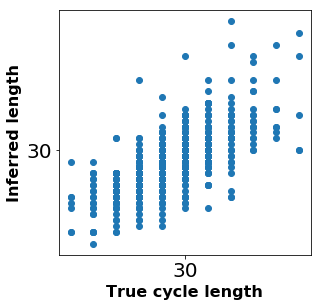

In [6]:
def plot_true_versus_inferred_cycle_length(model, samples, data_generator):
    """
    loop over all individuals in samples. For each individual, compare their model-inferred cycle length
    to their true cycle length (stored in data_generator). 
    Here, model-inferred cycle length is computed as the median number of timesteps between returns to state 0. 
    For the helper methods that compute this, see constants_and_util. 
    """
    true_cycle_lengths = []
    inferred_cycle_lengths = []
    errs = []
    for i, sample in enumerate(samples):
        viterbi_path = model.get_viterbi_path(sample)
        cycle_lengths = get_cycle_lengths(extract_stage_starts(viterbi_path == 0))
        if len(cycle_lengths) > 0:
            inferred_cycle_lengths.append(np.median(cycle_lengths))
            true_cycle_lengths.append(data_generator.all_individual_params[i]['cycle_length'])
            errs.append(np.abs(inferred_cycle_lengths[-1] - true_cycle_lengths[-1]))
        else:
            print("Warning! Could not compute cycle length for individual %i/%i." % (i + 1, len(samples)))
    plt.figure(figsize = [5, 5])
    plt.scatter(true_cycle_lengths, inferred_cycle_lengths)
    plt.xticks([30], fontsize = 20)
    plt.yticks([30], fontsize = 20)

    print 'Correlation between true and inferred cycle length: r = %2.3f; p = %2.3e' % pearsonr(inferred_cycle_lengths, true_cycle_lengths)
    print 'Median absolute error %2.1f; mean absolute error %2.1f' % (np.median(errs), np.mean(errs))
    plt.xlabel("True cycle length", fontsize = 16, fontweight = 'bold')
    plt.ylabel("Inferred length", fontsize = 16, fontweight = 'bold')
    plt.subplots_adjust(left = .2, bottom = .2)
    plt.show()
    
plot_true_versus_inferred_cycle_length(model, samples, data_generator)


# Binary data

Generate some simulated binary data. Again, the data is extremely noisy and the cycles are not at all visually obvious. The data generation procedure is similar to that for continuous data -- the probability that a feature is 1 oscillates sinusoidally. 

The parameter setting is {'trial_number': 0, 'noise': 25, 'verbose': True, 'cycle_variance_within_individuals': 2, 'min_T': 90, 'K': 10, 'sinusoid_coefficient_variation': 0.2, 'N': 500, 'max_T': 90, 'data_is_binary': True, 'cycle_variance_between_individuals': 2, 'n_sinusoids': 1, 'missing_data_probability': 0.2, 'population_cycle_length': 30, 'name': 'max_T'}


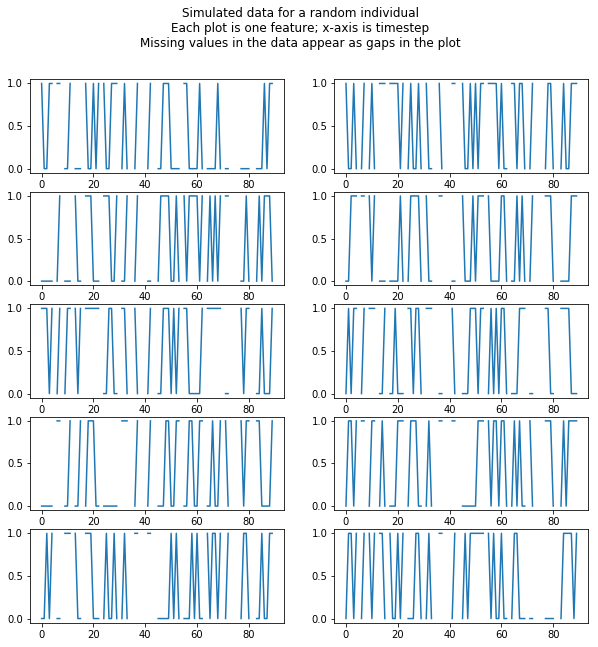

In [7]:
all_param_settings = generate_params_for_all_tests()
param_setting = all_param_settings[0]
param_setting.data_is_binary = True
print 'The parameter setting is', param_setting.__dict__
data_generator = simulatedDataGenerator(param_setting)
data_generator.generate_simulated_data()
samples = [a['sample'] for a in data_generator.all_individual_data]

Now we demonstrate how to fit the model on binary data. Model fitting is essentially the same with one important change: the emission distribution is now bernoulli_with_missing_data. 

In [8]:
model = cyclic_HMM.fit_cyhmm_model(n_states = 4, 
                                      samples = samples, 
                                      symptom_names = data_generator.symptoms, 
                                      max_iterations = 100, 
                                      duration_distribution_name = 'poisson', 
                                      emission_distribution_name = 'bernoulli_with_missing_data', 
                                      hypothesized_duration = 20, 
                                      verbose = True, 
                                      n_processes = 5,
                                     min_iterations = 10)


Initializing emission parameters from samples
Initializing emission parameters from samples
Initializing emission parameters from samples
Initializing emission parameters from samples
Time to do all model fitting 1.42858719826
After iteration 0 (total time: 1.518) parameters are
                      0         1         2         3
duration_mean  4.000393  3.999985  4.000191  3.999997
duration_std   2.000098  1.999996  2.000047  1.999999
p_missing      0.203133  0.204077  0.203258  0.203754
symptom_0_p    0.496742  0.498117  0.495205  0.494759
symptom_1_p    0.502471  0.499861  0.499738  0.499938
symptom_2_p    0.503885  0.495388  0.502453  0.504184
symptom_3_p    0.499762  0.498267  0.502656  0.498866
symptom_4_p    0.496825  0.496877  0.499270  0.493522
symptom_5_p    0.496869  0.505421  0.504796  0.504639
symptom_6_p    0.502240  0.500471  0.505395  0.500039
symptom_7_p    0.492503  0.496308  0.502063  0.500199
symptom_8_p    0.487008  0.484511  0.489948  0.489982
symptom_9_p    0.5

As before, the model correctly recovers the true cycle lengths. 

Correlation between true and inferred cycle length: r = 0.433; p = 2.881e-24
Median absolute error 2.0; mean absolute error 2.2


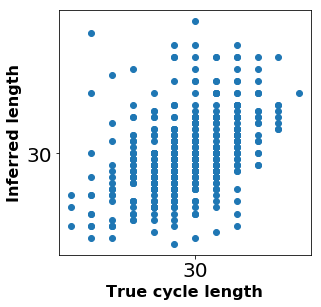

In [9]:
plot_true_versus_inferred_cycle_length(model, samples, data_generator)

In [10]:
if confirm_results_do_not_change:
    confirm_params_remain_the_same(model, 'final_binary_params.csv')

Model parameters are consistent with the original run.


# Clustering model

Last we demonstrate how to run the clustering model. First we generate some simulated data that has clusters. We generate data using two different data generators (with different randomly sampled parameters), drawing 500 samples from each data generator. The first 500 samples come from data_generator_1, and the last 500 samples come from data_generator_2 (we keep the samples in order for ease of exposition, but the model also accurately clusters randomly ordered samples). 

The simulated data parameter setting is {'trial_number': 0, 'noise': 25, 'verbose': True, 'cycle_variance_within_individuals': 2, 'min_T': 90, 'K': 10, 'sinusoid_coefficient_variation': 0.2, 'N': 500, 'max_T': 90, 'data_is_binary': False, 'cycle_variance_between_individuals': 2, 'n_sinusoids': 1, 'missing_data_probability': 0.2, 'population_cycle_length': 30, 'name': 'max_T'}


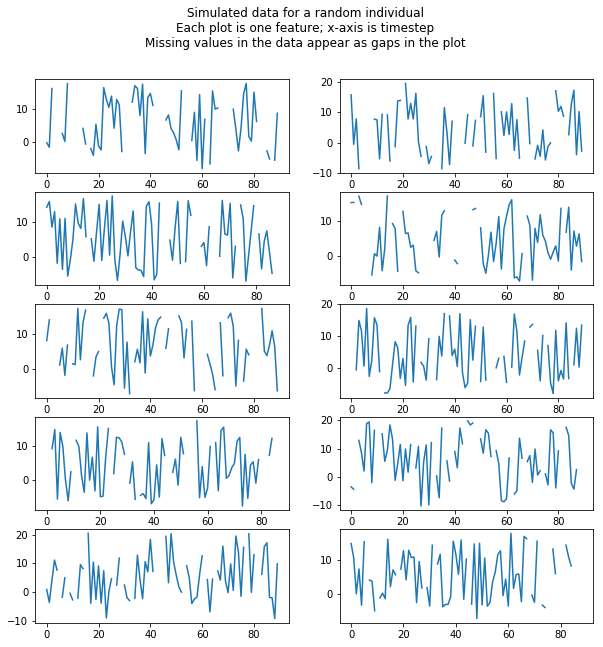

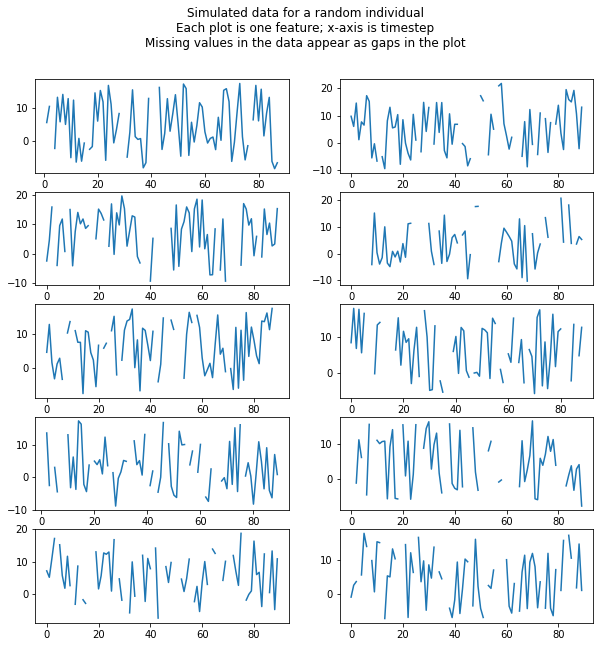

In [11]:
all_param_settings = generate_params_for_all_tests()
param_setting = all_param_settings[0]
print 'The simulated data parameter setting is', param_setting.__dict__
data_generator_1 = simulatedDataGenerator(param_setting)
data_generator_1.generate_simulated_data()
data_generator_2 = simulatedDataGenerator(param_setting)
data_generator_2.generate_simulated_data()
samples = [a['sample'] for a in data_generator_1.all_individual_data] + [a['sample'] for a in data_generator_2.all_individual_data]

In [12]:
cluster_model = cyclic_HMM.fit_clustering_model(n_states = 4, 
                         n_clusters = 2, 
                         samples = samples, 
                         symptom_names = data_generator.symptoms, 
                         duration_distribution_name = 'poisson', 
                         emission_distribution_name = 'normal_with_missing_data', 
                         hypothesized_duration = 20, 
                         n_samples_to_use_in_clustering = 50, 
                         max_clustering_iterations = 20)

Fitting clustering model with n_states = 4, n_clusters = 2, n_samples = 1000, n_symptoms = 10
Done with initial clustering
Counter({0: 508, 1: 492})




****Clustering iteration 0
Refitting clusters
Refitting cluster 0 with 508 samples
Fitting initial clustering model 0
Initializing emission parameters from samples
Initializing emission parameters from samples
Initializing emission parameters from samples
Initializing emission parameters from samples
Time to do all model fitting 1.47360801697
After iteration 0 (total time: 1.568) parameters are
                            0         1         2         3
duration_mean        4.000279  3.999939  4.000456  3.999933
duration_std         2.000069  1.999984  2.000113  1.999983
symptom_0_mean       4.953092  5.041877  4.960851  5.009273
symptom_0_p_missing  0.205125  0.205629  0.204717  0.207187
symptom_0_std        7.240891  7.239808  7.228787  7.239714
symptom_1_mean       4.950599  4.830842  4.925649  4.927654
symptom_1_p_missing  0.201305

After fitting the model and storing it as cluster_model, we can check the cluster assignments for each sample, provided by cluster_model.clustering. This shows that the samples are correctly partitioned into two clusters. 

In [13]:
print "Among the first 500 samples, cluster assignments are", Counter(cluster_model.clustering[:500])
print "Among the last 500 samples, cluster assignments are", Counter(cluster_model.clustering[-500:])

Among the first 500 samples, cluster assignments are Counter({0: 500})
Among the last 500 samples, cluster assignments are Counter({1: 500})


# Tips for best performance on your own data

Here are some things learned from using these models on various datasets. 

Make sure the model is converging to a solution that makes sense by performing some of the sanity checks described in the paper. The cycle detection / modeling problem can be quite difficult in real-world datasets, so it's important to check that the solution is plausible. Eg, does the inferred cycle length match what you think it should be? Do the inferred feature trajectories and most variable features make sense? (You can investigate this by eyeballing the model parameters which are printed out as the model is fit, or by using the functions in constants_and_util. Model parameters are printed out in a pandas dataframe where rows are parameters and columns are latent states. Note that the model parameter duration_mean is actually the amount of time spent in a state *minus one*, because the model counts down to 0. So if duration_mean is 5, the model spends 6 timesteps in a state.) 

If the model's solution does not make sense to you, it's of course possible that there are just no cycles in your data that the model can detect. But before concluding that, here are some things to check: 

1. Are you entering the data in the correct format, and encoding any missing data correctly? (See above.) 
2. Is the model terminating after only a couple iterations and barely moving from its initialization? If so, try increasing the min_iterations argument.
3. Do the model assumptions actually describe your data? For example, if your data has a strong downward time trend, it will be hard to describe using a model that assumes cycles, and you may want to detrend the data first. Or, if you suspect some of your features are cyclic but the vast majority of them are not, try fitting the model on the subset of cyclic features first. 
4. Have you set hypothesized_duration to your best guess of the true cycle length? As discussed in the paper, the model will not perform well if this parameter is wildly off. You can also try fitting the model with a range of hypothesized_duration to see which works best. 
5. Because the model is built on top of Pomegranate, which uses Cython objects, the entire model object should not be saved and reloaded as a Pickle or JSON, although the parameters can be saved. 

Please shoot an email to emmap1@cs.stanford.edu if you have further thoughts or questions!


